# Coastal Access & Amenities Analysis of Oʻahu, Hawaiʻi

## Overview

This project presents a spatial analysis of shoreline public access points and amenities on the island of Oʻahu, using GIS and Python. It evaluates how accessible Oʻahu’s coastline is by examining the availability of key public amenities that support safe, comfortable, and equitable shoreline use, including:
- Restrooms
- Showers
- Picnic facilities
- Trash receptacles
- Drinking water
- Phones
- Lifeguards

Using a combination of GIS shapefiles, CSV-based amenity data, and Python-driven spatial analysis, the project examines the distribution of shoreline access points, the density of coastal amenities, and regional patterns of well-served versus under-served areas. Results are explored through both statistical summaries and a fully interactive map of Oʻahu’s coastal access points.

## Part 1: Categorizing the data into regions

Before evaluating shoreline accessibility and the distribution of public amenities, it is essential to establish a clear spatial framework for analysis. Oʻahu’s coastline spans a wide range of environmental conditions, development patterns, and levels of public use, making direct point-to-point comparisons difficult without regional context. To address this, <b>the first step of this project categorizes shoreline public access points into four major coastal regions: North Shore, Windward Coast, South Shore, and Leeward Coast.</b>

Using a publicly available shoreline access shapefile, each access point is geospatially classified based on its latitude and longitude. Python-based spatial logic is applied to group locations according to their position relative to the island’s orientation, accounting for broad geographic distinctions such as eastern (windward), western (leeward), southern, and northern coastlines. These regional boundaries reflect well-established physical and cultural divisions across Oʻahu, including differences in wave exposure, land use, and infrastructure density.

Because real-world geography does not always conform perfectly to coordinate thresholds, select shoreline locations are manually reviewed and reassigned where necessary to ensure regional accuracy. This hybrid approach—combining automated spatial classification with targeted manual overrides—balances computational efficiency with geographic realism.

The resulting regional categorization provides the foundation for all subsequent analysis. By organizing shoreline access points into consistent coastal regions, the project can more effectively evaluate patterns in public amenity availability, identify well-served versus under-served areas, and support clear regional comparisons in both statistical analysis and interactive mapping.

In [35]:
import geopandas as gpd
import folium

# Load the shoreline shapefile
shp_path = "Shoreline_Public_Access.shp"
gdf = gpd.read_file(shp_path)

# Convert to WGS84 (lat/lon)
gdf = gdf.to_crs(epsg=4326)

# Add latitude & longitude columns from geometry
gdf["latitude"] = gdf.geometry.y
gdf["longitude"] = gdf.geometry.x


# Region classification function
def classify_region(lat, lon):
    # Windward Coast: east side, mid-to-northern latitudes
    if lon >= -157.90 and lat >= 21.35:
        return "Windward Coast"

    # Leeward Coast: far west side
    if lon <= -158.10:
        return "Leeward Coast"

    # South Shore: southern band of the island
    if lat <= 21.32:
        return "South Shore"

    # Everything else: northern arc = North Shore
    return "North Shore"


# Apply the classification
gdf["region"] = gdf.apply(
    lambda row: classify_region(row["latitude"], row["longitude"]),
    axis=1
)

# Manual regional overrides
south_shore_overrides = [
    "West Loch Shoreline Park",
    "Iriquois Point A",
    "Neil S Blaisdell Park",
    "Aiea Bay State Recreational Area",
    "Lagoon Drive",
    "Ke'ehi Lagoon Park"
]

windward_overrides = [
    "Bellows Field Beach Park",
    "Waimanalo Bay Beach Park",
    "Laumilo A",
    "Laumilo B",
    "Laumilo C",
    "Laumilo D",
    "Laumilo E",
    "Laumilo F",
    "Laumilo G",
    "Laumilo H",
    "Laumilo I",
    "Waimanalo Beach Park",
    "Kaiona Beach Park"
]

# Apply overrides
gdf.loc[gdf["name"].isin(south_shore_overrides), "region"] = "South Shore"
gdf.loc[gdf["name"].isin(windward_overrides), "region"] = "Windward Coast"

# See how many points per region
print(gdf["region"].value_counts())


# Build the folium map
center_lat = gdf["latitude"].mean()
center_lon = gdf["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

region_colors = {
    "North Shore": "green",
    "Leeward Coast": "red",
    "South Shore": "purple",
    "Windward Coast": "blue"
}

for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color=region_colors[row["region"]],
        fill=True,
        fill_opacity=0.9,
        popup=f"{row['name']}<br>Region: {row['region']}"
    ).add_to(m)

m

region
South Shore       74
Windward Coast    50
Leeward Coast     45
North Shore       40
Name: count, dtype: int64


<b>Coastline Map: Coastal Region Categorization</b>

## Part 2: Analysis

### a) Amenity Encoding overall Accessibility Analysis

With shoreline access points categorized into consistent coastal regions, the next phase of this project focuses on evaluating public amenity availability as a proxy for shoreline accessibility. Amenities such as restrooms, showers, drinking water, and lifeguard presence play a critical role in determining whether coastal access points are usable, safe, and inclusive for a wide range of users. Rather than treating accessibility as a binary concept, this analysis quantifies amenity presence to enable comparative, data-driven assessment across locations and regions.

Amenity data for each shoreline access point is first standardized by converting categorical responses (e.g., Yes, No, Unknown) into binary values. This normalization process ensures consistency across data sources and prepares the dataset for numerical analysis. Each amenity is treated as an equally weighted indicator of accessibility, reflecting the assumption that the absence of any basic facility can meaningfully limit shoreline use.

Using these binary indicators, an amenity score is calculated for each access point by summing the total number of available amenities. This composite score provides a simple yet effective measure of how well-equipped a shoreline location is, enabling direct comparisons between individual sites as well as aggregated analysis by coastal region.

The resulting amenity scores form the basis for identifying spatial patterns of well-served versus under-served shoreline areas. These metrics support subsequent regional comparisons, summary statistics, and visualization in an interactive map, allowing accessibility disparities to be explored at both local and island-wide scales.

In [36]:
# Define amenity_cols
amenity_cols = [
    "restroom", "showers", "picnic_fac",
    "trash_rece", "water", "phone", "lifeguard"
]

In [37]:
def to_binary(series):
    return (
        series.astype(str)
              .str.strip()
              .str.upper()
              .map({
                  "YES": 1,
                  "NO": 0,
                  "UNKNOWN": 0,
                  "Y": 1, "N": 0,   # just in case
                  "1": 1, "0": 0    # also in case
              })
              .fillna(0)
              .astype(int)
    )

# Apply conversion
for col in amenity_cols:
    gdf[col] = to_binary(gdf[col])

gdf[amenity_cols].head()

,restroom,showers,picnic_fac,trash_rece,water,phone,lifeguard
0,1,1,1,1,1,0,0
1,1,1,1,1,1,0,0
2,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1


In [38]:
gdf["amenity_score"] = gdf[amenity_cols].sum(axis=1)
gdf[["amenity_score"] + amenity_cols].head()

,amenity_score,restroom,showers,picnic_fac,trash_rece,water,phone,lifeguard
0,5,1,1,1,1,1,0,0
1,5,1,1,1,1,1,0,0
2,7,1,1,1,1,1,1,1
3,7,1,1,1,1,1,1,1
4,7,1,1,1,1,1,1,1


In [39]:
print("Amenity Counts:\n")
for col in amenity_cols:
    print(f"{col}: {gdf[col].sum()}")

Amenity Counts:

restroom: 79
showers: 72
picnic_fac: 64
trash_rece: 132
water: 80
phone: 46
lifeguard: 29


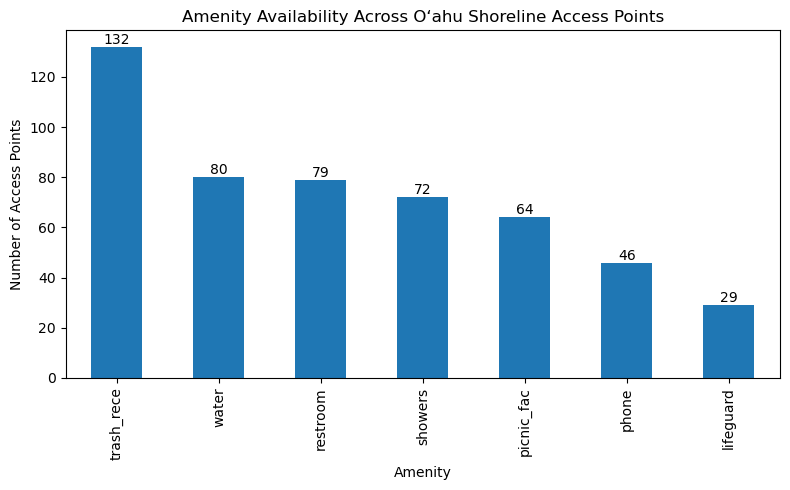

In [40]:
import matplotlib.pyplot as plt

amenity_counts = gdf[amenity_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
ax = amenity_counts.plot(kind="bar")

plt.title("Amenity Availability Across Oʻahu Shoreline Access Points")
plt.xlabel("Amenity")
plt.ylabel("Number of Access Points")

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [41]:
gdf["amenity_score"].describe()

count    209.000000
mean       2.401914
std        2.583453
min        0.000000
25%        0.000000
50%        1.000000
75%        5.000000
max        7.000000
Name: amenity_score, dtype: float64

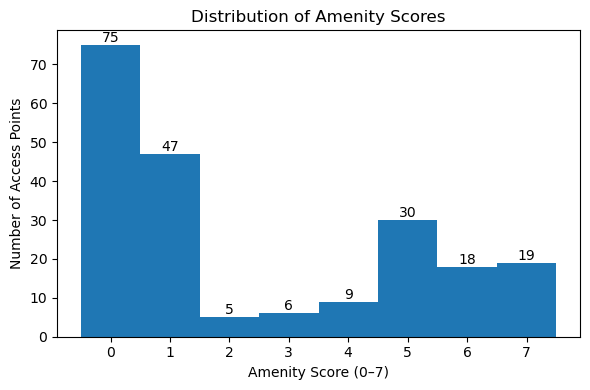

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

counts, bins, patches = plt.hist(
    gdf["amenity_score"],
    bins=range(0,9),
    align="left"
)

plt.title("Distribution of Amenity Scores")
plt.xlabel("Amenity Score (0–7)")
plt.ylabel("Number of Access Points")
plt.xticks(range(0,8))

# Add count labels above each bar
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            count,
            int(count),
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.tight_layout()
plt.show()

Overall, Oʻahu has 209 documented shoreline public access points, but the availability of amenities varies widely across locations. Basic infrastructure such as trash receptacles (132 sites) and drinking water (80 sites) is relatively common, while more specialized or safety-related amenities are far less prevalent. Only 29 access points have lifeguard coverage, and 46 provide access to public phones, highlighting notable gaps in emergency and safety support along the coastline.

Amenity scores further illustrate this uneven distribution. While some access points are well-equipped—with a maximum score of 7 amenities—many offer limited or no facilities at all. The median amenity score is 1, and approximately 25% of access points provide zero amenities, indicating that a significant portion of Oʻahu’s shoreline access locations lack even the most basic public infrastructure. Together, these results suggest that shoreline accessibility across the island is highly variable, with clear distinctions between well-served and under-served coastal areas.

The distribution of amenity scores further shows a strongly uneven pattern across Oʻahu’s shoreline access points. A substantial number of locations provide little to no infrastructure, with 75 access points offering zero amenities and 47 locations offering only one. In contrast, fewer sites fall in the mid-range of amenity availability, while a smaller but notable group of access points are well-equipped, with 67 locations providing five or more amenities. This bimodal distribution highlights a clear divide between minimally serviced shoreline areas and a smaller set of highly developed access points, reinforcing the presence of pronounced accessibility disparities along the island’s coast.

### b) Regional Analysis by Coastal Zone

While island-wide summaries provide a useful overview of shoreline accessibility, they can mask important regional differences driven by geography, development patterns, and coastal use. To better understand how public amenities are distributed across Oʻahu, this section breaks down amenity availability and accessibility scores by the island’s four primary coastal regions: North Shore, Windward Coast, South Shore, and Leeward Coast.

By analyzing amenity counts and composite amenity scores within each coastal zone, this regional approach highlights spatial disparities that are not visible in aggregate statistics alone. Comparing regions allows for identification of areas that are consistently well-served, as well as regions where limited infrastructure may restrict shoreline access, safety, or usability. This breakdown also provides context for how natural exposure, population density, and recreational demand influence the presence of public amenities along different parts of the coastline.

Together, this regional analysis supports a more nuanced understanding of shoreline accessibility across Oʻahu and lays the groundwork for identifying targeted opportunities for infrastructure investment, planning improvements, and equitable coastal access.

In [25]:
region_means = gdf.groupby("region")[amenity_cols + ["amenity_score"]].mean()
region_means

,restroom,showers,picnic_fac,trash_rece,water,phone,lifeguard,amenity_score
region,,,,,,,,
Leeward Coast,0.577778,0.511111,0.355556,0.688889,0.555556,0.333333,0.133333,3.155556
North Shore,0.300000,0.300000,0.225000,0.800000,0.300000,0.125000,0.175000,2.225000
South Shore,0.351351,0.297297,0.337838,0.554054,0.364865,0.202703,0.121622,2.229730
Windward Coast,0.300000,0.300000,0.280000,0.560000,0.320000,0.220000,0.140000,2.120000


Average amenity availability varies notably across Oʻahu’s four coastal regions. The Leeward Coast consistently shows the highest levels of infrastructure, with the highest mean amenity score (3.16) among all regions. This coastline also has the greatest average presence of restrooms, showers, drinking water, and trash receptacles, suggesting a higher concentration of well-equipped shoreline access points relative to other parts of the island.

In contrast, the North Shore, South Shore, and Windward Coast exhibit lower and relatively similar overall amenity scores, ranging from approximately 2.12 to 2.23. While trash receptacles are common across all regions—particularly along the North Shore—other amenities such as showers, phones, and lifeguard coverage are far less prevalent. Notably, lifeguard presence remains low across every coastline, with regional averages below 0.18, highlighting a consistent gap in safety-related infrastructure.

These results indicate that shoreline accessibility on Oʻahu is not evenly distributed and is influenced by regional patterns of development and use. The higher amenity concentration along the Leeward Coast contrasts with more sparsely equipped access points elsewhere, underscoring the importance of regional context when evaluating coastal access and identifying under-served areas.

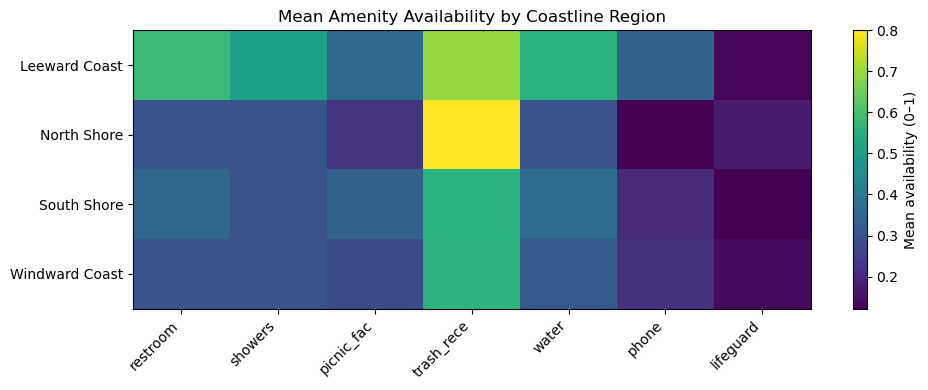

In [30]:
import matplotlib.pyplot as plt

# Select only binary amenity columns
heat = region_means[amenity_cols]

plt.figure(figsize=(10,4))
plt.imshow(heat.values, aspect="auto")
plt.colorbar(label="Mean availability (0–1)")

plt.xticks(range(len(heat.columns)), heat.columns, rotation=45, ha="right")
plt.yticks(range(len(heat.index)), heat.index)

plt.title("Mean Amenity Availability by Coastline Region")
plt.tight_layout()
plt.show()

<b>Heatmap Overview: Amenity Availability by Coastline</b>

This heatmap visualizes the average availability of individual public amenities across Oʻahu’s four coastal regions. Each row represents a coastline region, and each column represents a specific amenity. Color intensity reflects the proportion of shoreline access points within each region that provide that amenity, with purple-leaning colors indicating lower availability and greener colors indicating higher availability.

Because all values are normalized on a 0–1 scale, the heatmap allows for direct comparison both across amenities within a single region and between regions for the same amenity. This visualization highlights regional patterns in infrastructure provision and makes disparities in shoreline accessibility immediately apparent, particularly for amenities related to safety, comfort, and basic public use.

In [31]:
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color=region_colors[row["region"]],
        fill=True,
        fill_opacity=0.9,
        popup=(
            f"<b>{row['name']}</b><br>"
            f"Region: {row['region']}<br>"
            f"Amenity score: {int(row['amenity_score'])} / 7"
        ),
        tooltip=f"Amenity score: {int(row['amenity_score'])}"
    ).add_to(m)


In [32]:
m

<b>Coastline Map: Complete with Amenity Score</b>

This interactive map builds on the previously categorized shoreline regions by displaying the same public access points now enriched with amenity scores for each location. Points remain color-coded by coastline region (North Shore, Windward Coast, South Shore, and Leeward Coast), while popups and hover tooltips provide the composite amenity score associated with each access point. By combining regional context with quantitative accessibility metrics, the map allows users to explore how shoreline infrastructure varies both geographically and at the individual site level.

In [34]:
# Color mapping for amenity scores (0–7)
score_colors = {
    0: "#d73027",  # red
    1: "#f46d43",
    2: "#fdae61",
    3: "#fee08b",
    4: "#d9ef8b",
    5: "#a6d96a",
    6: "#66bd63",
    7: "#1a9850"   # dark green
}

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

for _, row in gdf.iterrows():
    score = int(row["amenity_score"])
    
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color=score_colors.get(score, "#999999"),
        fill=True,
        fill_color=score_colors.get(score, "#999999"),
        fill_opacity=0.9,
        popup=(
            f"<b>{row['name']}</b><br>"
            f"Region: {row['region']}<br>"
            f"Amenity score: {score} / 7"
        ),
        tooltip=f"Amenity score: {score}"
    ).add_to(m)

m

<b>Coastline Map: Colored by Amenity Score<b/>

This map visualizes shoreline accessibility using a thematic color scale based on amenity score, where each access point is colored according to the total number of amenities available (0–7). Warmer colors indicate fewer amenities, while cooler colors represent more fully equipped access points. This view highlights spatial clustering of well-served and under-served shoreline locations and provides an intuitive comparison of accessibility across the island.
    
When viewed alongside the regional map above, this visualization clarifies which coastline regions tend to be better equipped with public amenities and which exhibit more limited infrastructure.

## Conclusion

This project demonstrates that shoreline accessibility on Oʻahu varies widely across both regions and individual access points. While some coastline areas are consistently well-equipped with public amenities, many shoreline locations provide limited or no supporting infrastructure. By combining GIS-based spatial classification with amenity-level analysis and interactive mapping, this study highlights clear patterns of disparity in shoreline access and underscores the importance of regional context when evaluating coastal infrastructure. Together, these findings provide a foundation for future work focused on improving equitable, safe, and inclusive access to Oʻahu’s coastline.